### Time-Series w/ Prophet

Q: What do We want to predict?

A: We want to predict the number (count) of reviews over time. Essentially we want to predict the variations in customer engagement, whether it's negative or positive.

In [20]:
#install
!pip install prophet

In [21]:
# imports
import prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Firstly, since we need data from both the business and the reviews data, it is best to merge them.

In [23]:
# read the data
# Initialize an empty DataFrame to store the data
reviews = pd.DataFrame()

# Define the file path
file_path = '/gdrive/My Drive/ADC/yelp_project/datasets/review_community_1.csv'

# Specify the chunk size
chunksize = 100000

# Read the file in chunks and concatenate them
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    reviews = pd.concat([reviews, chunk])

# Now, 'reviews' contains the entire dataset

In [24]:
# show the data
reviews.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,ymhbOMW63B_vGaRFR3XT0A,yZdAhQ_KmKuCZmbBy9YDQg,5Ce3lZksYVkCbrihqylVHQ,5,0,0,0,I just started going to Sushi Nara this month ...,2014-07-25 17:56:26
1,9ntCEU8M_YBa0TIxxM1roA,BMXA8HiAuOQboRikPt6Xgg,XyGRDrgCK0z4CiA6nhwEaw,3,3,2,0,Ok. I have had Persian food before as it is on...,2018-07-17 02:44:51
2,KubhmZ6MADKfAh0TucXZeQ,iW4scl2ezCV6IGfOk6OtyQ,xwKYBPO0ByGlkvNcr8FdqQ,5,0,0,0,"Always outstanding. This evening, they were a ...",2017-04-30 03:57:53
3,jT0mpPypQH_eFoyIHhuM6A,To1Pq4io8oCT8f6ryRdPeQ,5Ce3lZksYVkCbrihqylVHQ,5,2,0,3,My kitty and I love this sushi place!! We love...,2015-10-07 23:33:00
4,mr8-n6rmPXqgAe0O5YG0jQ,4RZJaKdymRQ5z59ZMFznTQ,xwKYBPO0ByGlkvNcr8FdqQ,5,2,0,1,I took my gf for our one year anniversary here...,2014-09-10 04:16:53


In [25]:
# read business data
business = pd.read_csv('/gdrive/My Drive/ADC/yelp_project/datasets/business_community_1.csv')

In [26]:
# show business data
business.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.046320,4.5,258,1,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
1,5Ce3lZksYVkCbrihqylVHQ,Sushi Nara,64 N Harrison Rd,Tucson,AZ,85748,32.222552,-110.788132,4.5,159,1,"{'RestaurantsPriceRange2': '2', 'HasTV': 'True...","Sushi Bars, Japanese, Restaurants","{'Monday': '16:30-20:0', 'Tuesday': '16:30-20:..."
2,xwKYBPO0ByGlkvNcr8FdqQ,Le Rendez-vous,3844 E Fort Lowell Rd,Tucson,AZ,85716,32.264930,-110.910544,4.0,223,1,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, French, Tapas/Small Plates","{'Wednesday': '16:0-21:0', 'Thursday': '16:0-2..."
3,SVJJIoAiW3vHwoSpVnUcLQ,Pastiche Modern Eatery,3025 N Campbell Ave,Tucson,AZ,85719,32.261920,-110.944474,3.5,313,1,"{'WiFi': ""'free'"", 'HasTV': 'True', 'Restauran...","American (New), American (Traditional), Restau...","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."
4,p7tSGmWpFV246aYhwODgBg,O Sushi Restaurant,4689 E Speedway Blvd,Tucson,AZ,85712,32.236944,-110.892965,4.5,199,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Sushi Bars, Restaurants, Japanese","{'Monday': '16:30-20:30', 'Tuesday': '16:30-20..."
5,aDL_KdxbDRT5s51Jtn9V5g,Charro del Rey,178 E Broadway Blvd,Tucson,AZ,85701,32.221064,-110.967489,4.0,223,0,"{'RestaurantsReservations': 'True', 'Ambience'...","Mexican, Restaurants, Seafood","{'Thursday': '15:0-21:0', 'Friday': '15:0-21:0..."
6,wzPc5d1l0PpxQLQDhh8T2w,Toro Loco,7940 E Broadway Blvd,Tucson,AZ,85710,32.220550,-110.822602,4.0,153,0,"{'WheelchairAccessible': 'True', 'RestaurantsT...","Tacos, Restaurants, Mexican","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
7,Wp9D-r8Ap1Fv0IIM0zGfoQ,Bisbee Breakfast Club,"410 N Wilmot Rd, Ste 110",Tucson,AZ,85711,32.226039,-110.857387,4.0,144,1,"{'WiFi': ""u'no'"", 'OutdoorSeating': 'True', 'D...","Restaurants, American (Traditional), Breakfast...","{'Monday': '6:0-14:0', 'Tuesday': '6:0-14:0', ..."
8,5CX7rtnwYnmqFCihOyWivg,Opa's Best Greek American Cuisine,4590 E Broadway Blvd,Tucson,AZ,85711,32.221171,-110.894790,4.5,230,1,"{'RestaurantsTakeOut': 'True', 'WheelchairAcce...","Mediterranean, Restaurants, Greek","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
9,CJoO4HYD0tZRXlZqA04wmw,Crave Coffee Bar,4530 E Broadway,Tucson,AZ,85711,32.221115,-110.895852,4.5,435,1,"{'RestaurantsReservations': 'False', 'Restaura...","Food, Coffee & Tea, Restaurants","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ..."


In [27]:
# join the files using business id
tucson_sample = pd.merge(business, reviews, on='business_id')

In [28]:
# show the new data
tucson_sample.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",9ntCEU8M_YBa0TIxxM1roA,BMXA8HiAuOQboRikPt6Xgg,3,3,2,0,Ok. I have had Persian food before as it is on...,2018-07-17 02:44:51
1,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",9hHfYB3Ch3HsSJ-pzywOpw,q2dv-IDg5zKJP6XgA-msZw,5,0,0,0,My wife and I really like this place. Today wa...,2018-07-17 05:17:55
2,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",1a4BtVOSqEKIr3zZfZZFBg,zAFgnKwrygxSp1kXzdvMMA,3,0,0,0,My family and I were super excited that Persia...,2018-07-17 15:26:09
3,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",vSIf7GznM31ovbf7_xpxKA,SOYxjwvaQuxNy44ac0h44A,5,0,0,0,Thank you for opening your new restaurant in T...,2018-09-05 23:04:25
4,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",jQQzpPYhmSEpL30qcm6Ydw,tD_oQ0dmCtFmj-_MSHdEsA,5,1,0,2,So glad to see this restaurant open. A welcome...,2018-06-27 02:20:54
5,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",bV2CSWDP9-fil9zBH8OFJA,6T_Uwq5eKhWYjm9ch95vpg,5,2,0,1,Delicious and different. No discounted lunch m...,2018-07-28 19:34:39
6,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",_FP-FKtsLRT5_gwhrjHDbg,A8A0VqCmDxxjp0k7wllMcw,5,3,0,1,"Excellent food, excellent dining experience.\n...",2018-07-10 02:44:04
7,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",BnDz-prHrNl5zN37Sf8qGw,dCrTvwqqjv96pEGL2RBkgA,5,2,0,0,So excited to have our very own Persian Room i...,2018-07-10 01:44:30
8,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",h6AcslAew9wqyosJQI5XXQ,rnPHWYEj6yf4qb8h8EhmcA,4,0,0,0,This is a beautiful restaurant. They have an ...,2018-07-19 02:54:14
9,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,85742,32.375016,-111.04632,4.5,258,...,"Restaurants, Persian/Iranian, Mediterranean","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3...",7tvt489pmDvLi7vWsIlmMg,la-rk4Dv2g4mcxQs6Q8QUg,5,3,0,1,Big thank you to Patrick for being a great ser...,2018-07-27 19:43:23


After having the final (community 1) data, we can start by working and preparing our data for Prophet.

In [29]:
# show the columns
tucson_sample.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id', 'stars_y',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')

Here we just drop some columns which we decided would not be relevant or impactful in our analysis.

In [30]:
# drop unnecessary columns
columns_to_drop = ['postal_code', 'latitude', 'longitude', 'is_open', 'hours', 'useful', 'funny', 'cool']

# Use the drop method to remove the specified columns
tucson_sample = tucson_sample.drop(columns=columns_to_drop)

In [31]:
# show columns again
tucson_sample.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'stars_x',
       'review_count', 'attributes', 'categories', 'review_id', 'user_id',
       'stars_y', 'text', 'date'],
      dtype='object')

Now we can plot a simple histogram just to detect some outliers, and afterwards, remove them.

<Axes: ylabel='Frequency'>

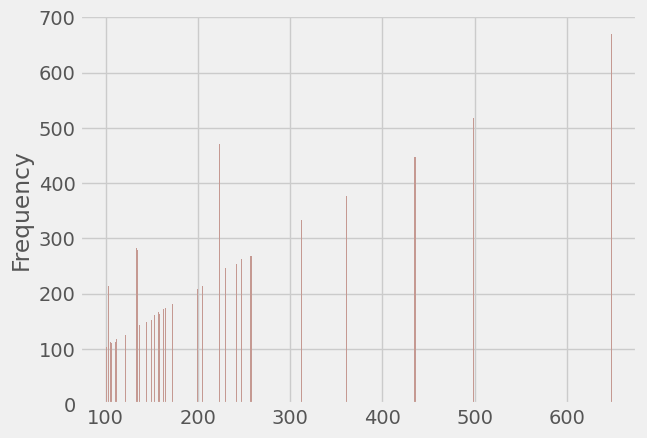

In [32]:
# outlier detection
tucson_sample['review_count'].plot(kind='hist', bins=500, color='#c59992')

In [33]:
# remove extreme outliers
tucson_sample = tucson_sample.query('review_count < 300').copy()

Finally, we set the date to be the index in our data, which will be very helpful moving forward with our work.

In [34]:
# set the date to index
tucson_sample = tucson_sample.set_index('date')
tucson_sample.index = pd.to_datetime(tucson_sample.index)

In [35]:
# show the data
tucson_sample.head()

,business_id,name,address,city,state,stars_x,review_count,attributes,categories,review_id,user_id,stars_y,text
date,,,,,,,,,,,,,
2018-07-17 02:44:51,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,4.5,258,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean",9ntCEU8M_YBa0TIxxM1roA,BMXA8HiAuOQboRikPt6Xgg,3,Ok. I have had Persian food before as it is on...
2018-07-17 05:17:55,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,4.5,258,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean",9hHfYB3Ch3HsSJ-pzywOpw,q2dv-IDg5zKJP6XgA-msZw,5,My wife and I really like this place. Today wa...
2018-07-17 15:26:09,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,4.5,258,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean",1a4BtVOSqEKIr3zZfZZFBg,zAFgnKwrygxSp1kXzdvMMA,3,My family and I were super excited that Persia...
2018-09-05 23:04:25,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,4.5,258,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean",vSIf7GznM31ovbf7_xpxKA,SOYxjwvaQuxNy44ac0h44A,5,Thank you for opening your new restaurant in T...
2018-06-27 02:20:54,XyGRDrgCK0z4CiA6nhwEaw,Persian Room Fine Dining,"9290 N Thornydale Rd, Ste 100",Tucson,AZ,4.5,258,"{'Alcohol': ""'full_bar'"", 'GoodForMeal': ""{'de...","Restaurants, Persian/Iranian, Mediterranean",jQQzpPYhmSEpL30qcm6Ydw,tD_oQ0dmCtFmj-_MSHdEsA,5,So glad to see this restaurant open. A welcome...


### Time-Series with Prophet

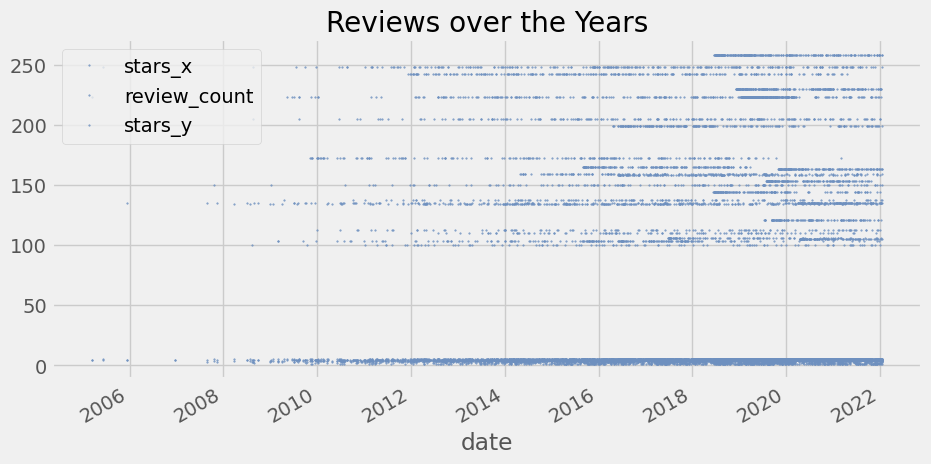

In [36]:
# plot the data
color_pal = sns.color_palette('vlag')
tucson_sample.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Reviews over the Years')
plt.show()

Here we are separating our date into different features, such as:
- hour
- day of the week
- year
- etc.

In [37]:
# creating features to separate the data into days, month, year, season, etc.
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(tucson_sample, label='review_count')
features_and_target = pd.concat([X, y], axis=1)

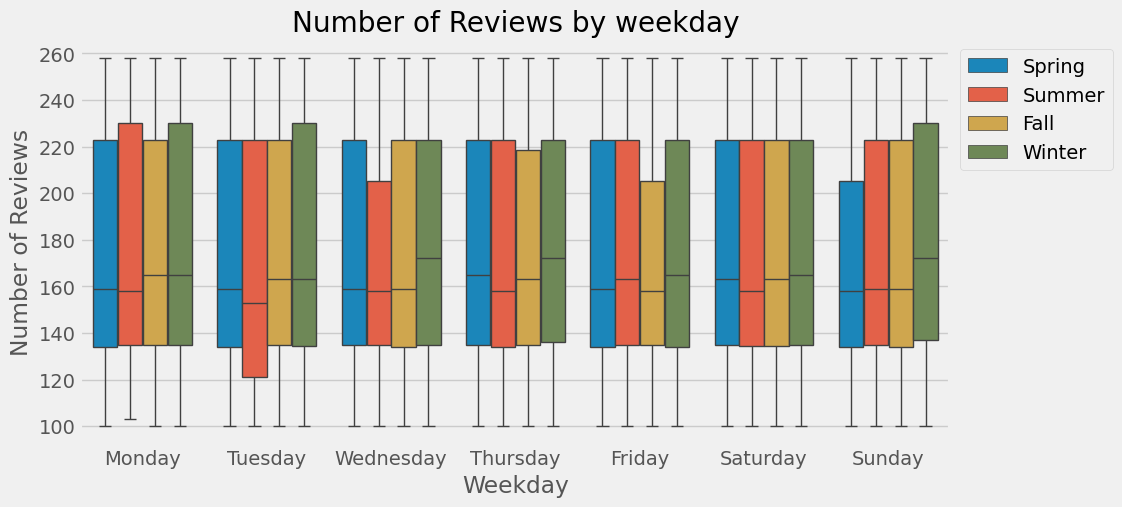

In [38]:
# plot data by season
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='review_count',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Number of Reviews by weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Reviews')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Starting with our true Prophet analysis, we split our data for training and testing (which in this case will be in 2017, equivalent to a 70/30 split).

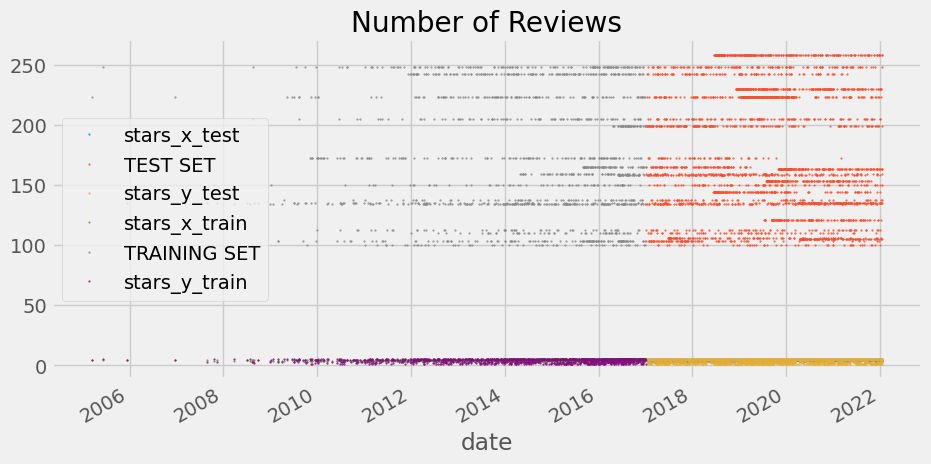

In [39]:
# starting with ml pipeline
#train-> grey | test-> red
split_date = '1-Jan-2017'
tucson_train = tucson_sample.loc[tucson_sample.index <= split_date].copy()
tucson_test = tucson_sample.loc[tucson_sample.index > split_date].copy()

# add suffixes to the columns
tucson_train = tucson_train.add_suffix('_train')
tucson_test = tucson_test.add_suffix('_test')

# plot train and test
tucson_test \
    .rename(columns={'review_count_test': 'TEST SET'}) \
    .join(tucson_train.rename(columns={'review_count_train': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Number of Reviews', style='.', ms=1)
plt.show()

In [40]:
# format data for prophet model using ds and y: ds should be our datetime data, and y should be our target data
tucson_train_prophet = tucson_train.reset_index() \
    .rename(columns={'date':'ds',
                     'review_count_train':'y'})
tucson_train_prophet.columns

Index(['ds', 'business_id_train', 'name_train', 'address_train', 'city_train',
       'state_train', 'stars_x_train', 'y', 'attributes_train',
       'categories_train', 'review_id_train', 'user_id_train', 'stars_y_train',
       'text_train'],
      dtype='object')

In [41]:
# creating the prophet model using default features
from prophet import Prophet

model = Prophet()
model.fit(tucson_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3s2ic738/vyfbx3mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3s2ic738/kkr0g7lp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86489', 'data', 'file=/tmp/tmp3s2ic738/vyfbx3mr.json', 'init=/tmp/tmp3s2ic738/kkr0g7lp.json', 'output', 'file=/tmp/tmp3s2ic738/prophet_model_g6oj0_1/prophet_model-20231009073619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Since prophet only takes a particular nomenclature, we have to change the name of our data an target columns:

In [42]:
# after training the model, we can run the 'predict' command
# predict on test set
tucson_test_prophet = tucson_test.reset_index() \
    .rename(columns={'date':'ds',
                     'review_count_test':'y'})

tucson_test_frcst = model.predict(tucson_test_prophet)

In [43]:
# show the new dataframe
tucson_test_frcst.head() #yhat (last column) represents the predictive value(s)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-03 03:36:48,169.844361,102.863137,222.180302,169.844361,169.844361,-4.094408,-4.094408,-4.094408,4.006441,...,-3.328463,-3.328463,-3.328463,-4.772386,-4.772386,-4.772386,0.0,0.0,0.0,165.749953
1,2017-01-05 02:04:04,169.842838,111.549118,234.308923,169.842838,169.842838,4.115024,4.115024,4.115024,1.367263,...,6.002564,6.002564,6.002564,-3.254803,-3.254803,-3.254803,0.0,0.0,0.0,173.957862
2,2017-01-05 02:05:55,169.842837,113.573286,236.626985,169.842837,169.842837,4.183972,4.183972,4.183972,1.436992,...,6.000667,6.000667,6.000667,-3.253686,-3.253686,-3.253686,0.0,0.0,0.0,174.026810
3,2017-01-05 21:29:00,169.842202,106.384545,230.183181,169.842202,169.842202,-3.057653,-3.057653,-3.057653,-1.784502,...,1.254816,1.254816,1.254816,-2.527967,-2.527967,-2.527967,0.0,0.0,0.0,166.784549
4,2017-01-05 22:55:42,169.842155,103.394714,234.294249,169.842155,169.842155,-1.783199,-1.783199,-1.783199,-0.133119,...,0.822056,0.822056,0.822056,-2.472136,-2.472136,-2.472136,0.0,0.0,0.0,168.058956


Here we have the Prophet forecast on years whose real values we already have.

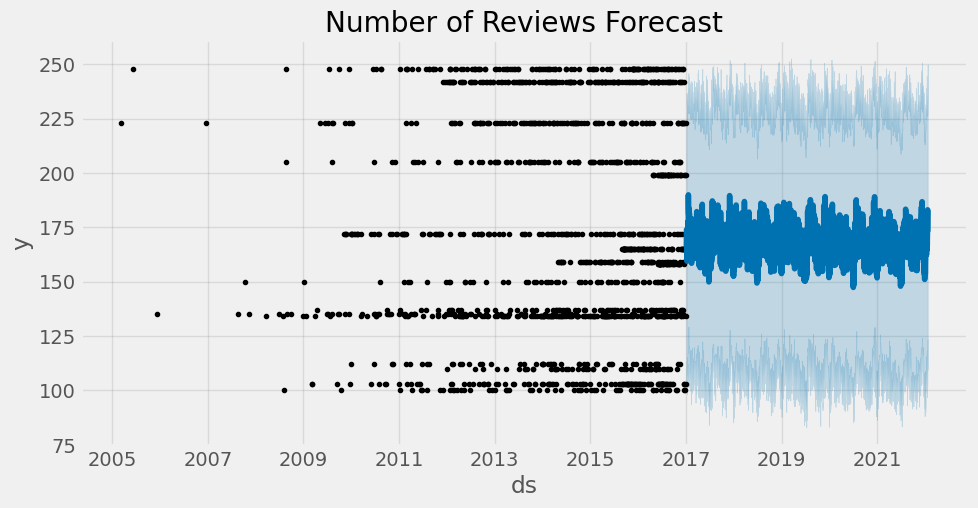

In [44]:
# plot the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(tucson_test_frcst, ax=ax)
ax.set_title('Number of Reviews Forecast')
plt.show() # y represents the target (number of reviews) and ds represents the date, which in this case is in years
# along with the predictions (in dark blue), we also have confidence intervals (in lighter blue)

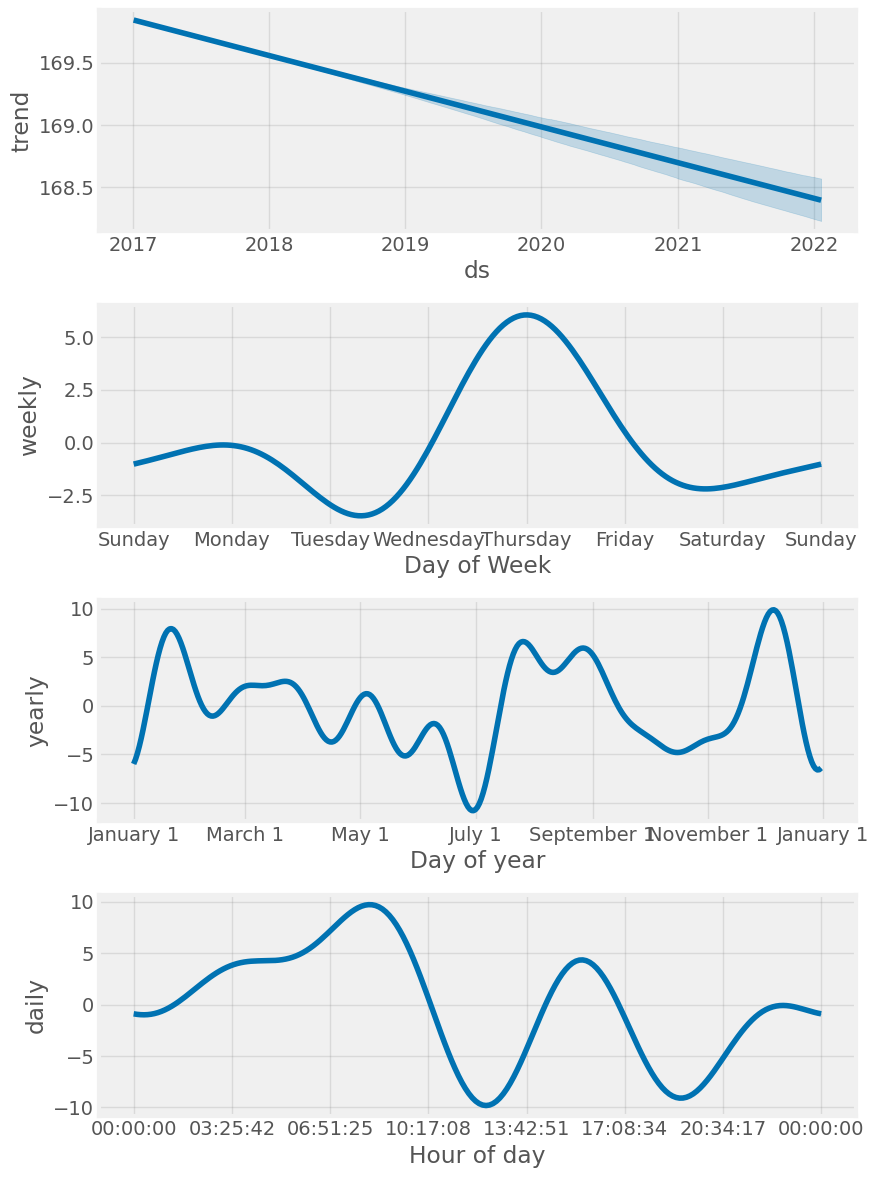

In [45]:
# lets plot the different prophet components of the data frame
fig = model.plot_components(tucson_test_frcst)
plt.show() # trend | weekly | yearly | daily
# the model combined these components to create the forecast above

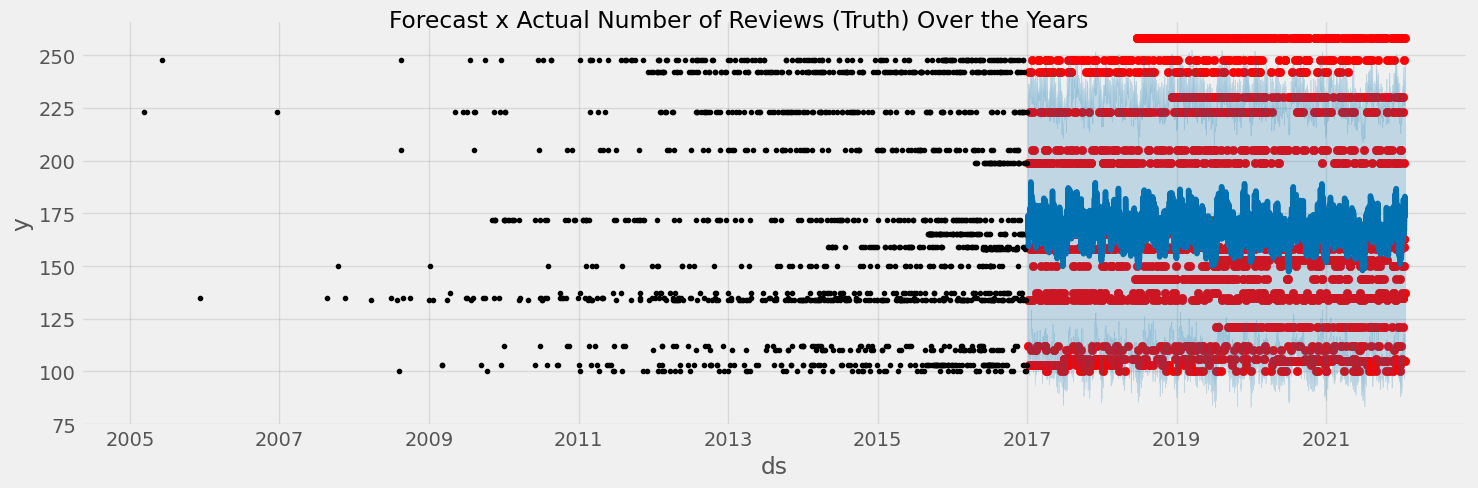

In [46]:
# evaluate the model
# let's compare the forecast with the actual number of reviews for each year
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)
plot = plt.suptitle('Forecast x Actual Number of Reviews (Truth) Over the Years')
# red-> actual values | blue-> predicted values | it looks like prophet picked up a downward trend

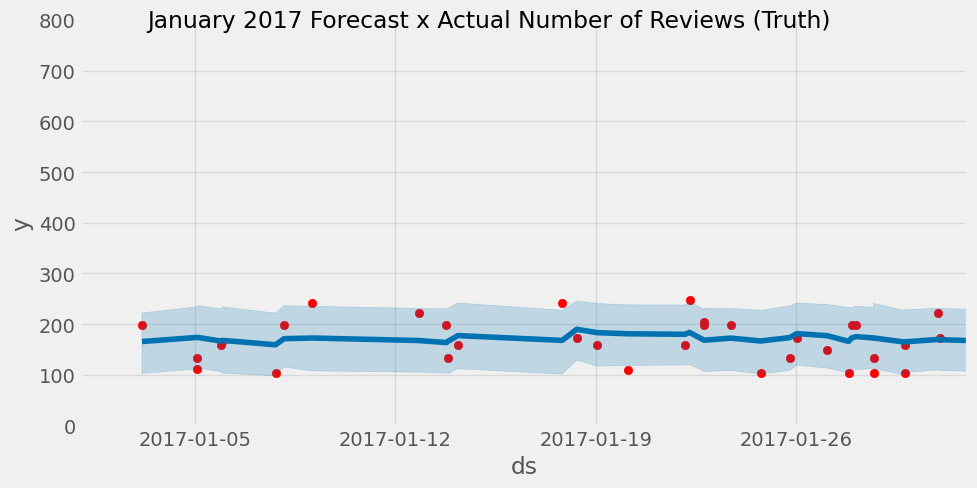

In [47]:
# now let's look at a more narrow time window-> starting with the first month year of our prediction, which is january 2017
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)

from datetime import datetime

lower_date = datetime.strptime('2017-01-01', '%Y-%m-%d')
upper_date = datetime.strptime('2017-02-01', '%Y-%m-%d')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 800)
plot = plt.suptitle('January 2017 Forecast x Actual Number of Reviews (Truth)')

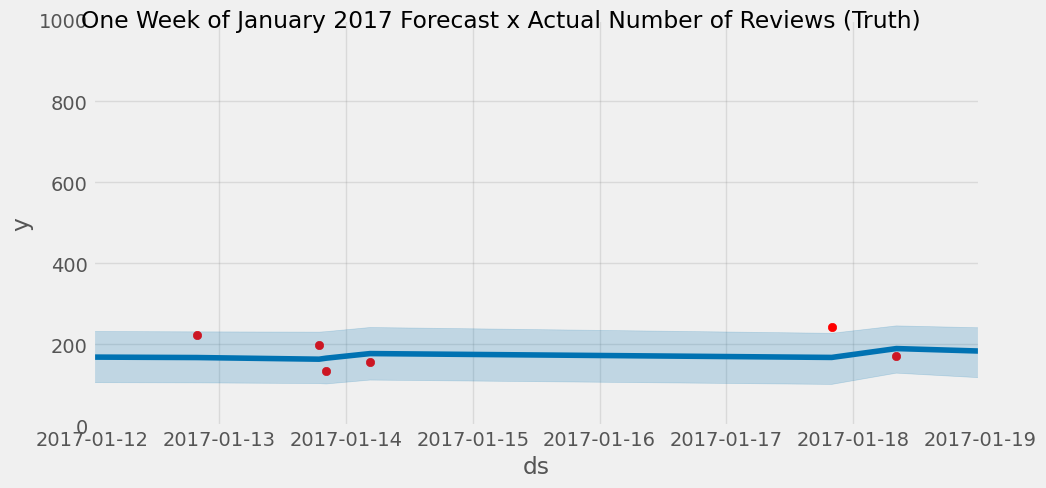

In [48]:
# now let's look at the one week! January 12th-19th 2017, since we can see above that the first two weeks don´t have reviews
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)

from datetime import datetime

lower_date = datetime.strptime('2017-01-12', '%Y-%m-%d')
upper_date = datetime.strptime('2017-01-19', '%Y-%m-%d')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 1000)
plot = plt.suptitle('One Week of January 2017 Forecast x Actual Number of Reviews (Truth)')

Evaluation metrics:
- Root Mean Square Error
- Mean Absolute Error
- Mean Absolute Percentage Error

In [49]:
# evaluate with error metrics
# root mean squared error | mean absolute error | mean absolute percent error
# RMSE
np.sqrt(mean_squared_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst['yhat']))
#/(tucson_test['review_count_test'].mean()) # better performance than xgboost

50.087208002993904

In [50]:
# MAE
mean_absolute_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst['yhat'])

43.09679458969991

In [51]:
# MAPE
# percent value that is 'off' on average
mean_absolute_percentage_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst['yhat'])

25.59322183864981

In [52]:
from prophet.diagnostics import cross_validation
tucson_cv = cross_validation(model, horizon='365 days')

INFO:prophet:Making 16 forecasts with cutoffs between 2008-07-04 09:47:25 and 2016-01-01 21:47:25


  0%|          | 0/16 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3s2ic738/wd53n824.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3s2ic738/k5wzc7l_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5776', 'data', 'file=/tmp/tmp3s2ic738/wd53n824.json', 'init=/tmp/tmp3s2ic738/k5wzc7l_.json', 'output', 'file=/tmp/tmp3s2ic738/prophet_model5b3aa3n1/prophet_model-20231009073627.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:36:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3s2ic738/n0hn064h.json
DEBUG:cmdstanpy:input tempfile

In [53]:
from prophet.diagnostics import performance_metrics
tucson_p = performance_metrics(tucson_cv)
tucson_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,41 days 17:12:04,199912.555190,447.115819,95.464217,0.663144,0.266755,0.344121,0.641304
1,41 days 21:26:09,199896.317261,447.097660,95.265920,0.661027,0.265310,0.342614,0.644928
2,41 days 23:52:26,199888.803859,447.089257,95.164685,0.660533,0.265310,0.342017,0.644928
3,42 days 02:04:57,199903.891020,447.106129,95.323275,0.660854,0.266755,0.342563,0.644928
4,42 days 05:44:51,199897.613443,447.099109,95.277984,0.661666,0.266755,0.342677,0.648551


This section is an additional Prophet analysis, accounting for holidays in the USA.

In [54]:
# holidays-> since we are working with a city from the USA, we will take USA Holidays into consideration
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=tucson_sample.index.min(),
                        end=tucson_sample.index.max(),
                        return_name=True)
holiday_tucson = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_tucson = holiday_tucson.reset_index().rename(columns={'index':'ds'})

In [55]:
# show unique holidays/holiday
holiday_tucson.value_counts()

ds          holiday                            
2005-05-30  Memorial Day                           1
2016-12-26  Christmas Day                          1
2016-01-18  Birthday of Martin Luther King, Jr.    1
2016-02-15  Washington’s Birthday                  1
2016-05-30  Memorial Day                           1
                                                  ..
2011-01-17  Birthday of Martin Luther King, Jr.    1
2011-02-21  Washington’s Birthday                  1
2011-05-30  Memorial Day                           1
2011-07-04  Independence Day                       1
2022-01-17  Birthday of Martin Luther King, Jr.    1
Length: 170, dtype: int64

In [56]:
# create a new prophet model for the holidays dataset
model_with_holidays = Prophet(holidays=holiday_tucson)
model_with_holidays.fit(tucson_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3s2ic738/ict89t1z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3s2ic738/pzr0aj3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59679', 'data', 'file=/tmp/tmp3s2ic738/ict89t1z.json', 'init=/tmp/tmp3s2ic738/pzr0aj3n.json', 'output', 'file=/tmp/tmp3s2ic738/prophet_modelk53del75/prophet_model-20231009073708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [57]:
# predict on training set
tucson_test_frcst_with_hols = \
    model_with_holidays.predict(df=tucson_test_prophet)

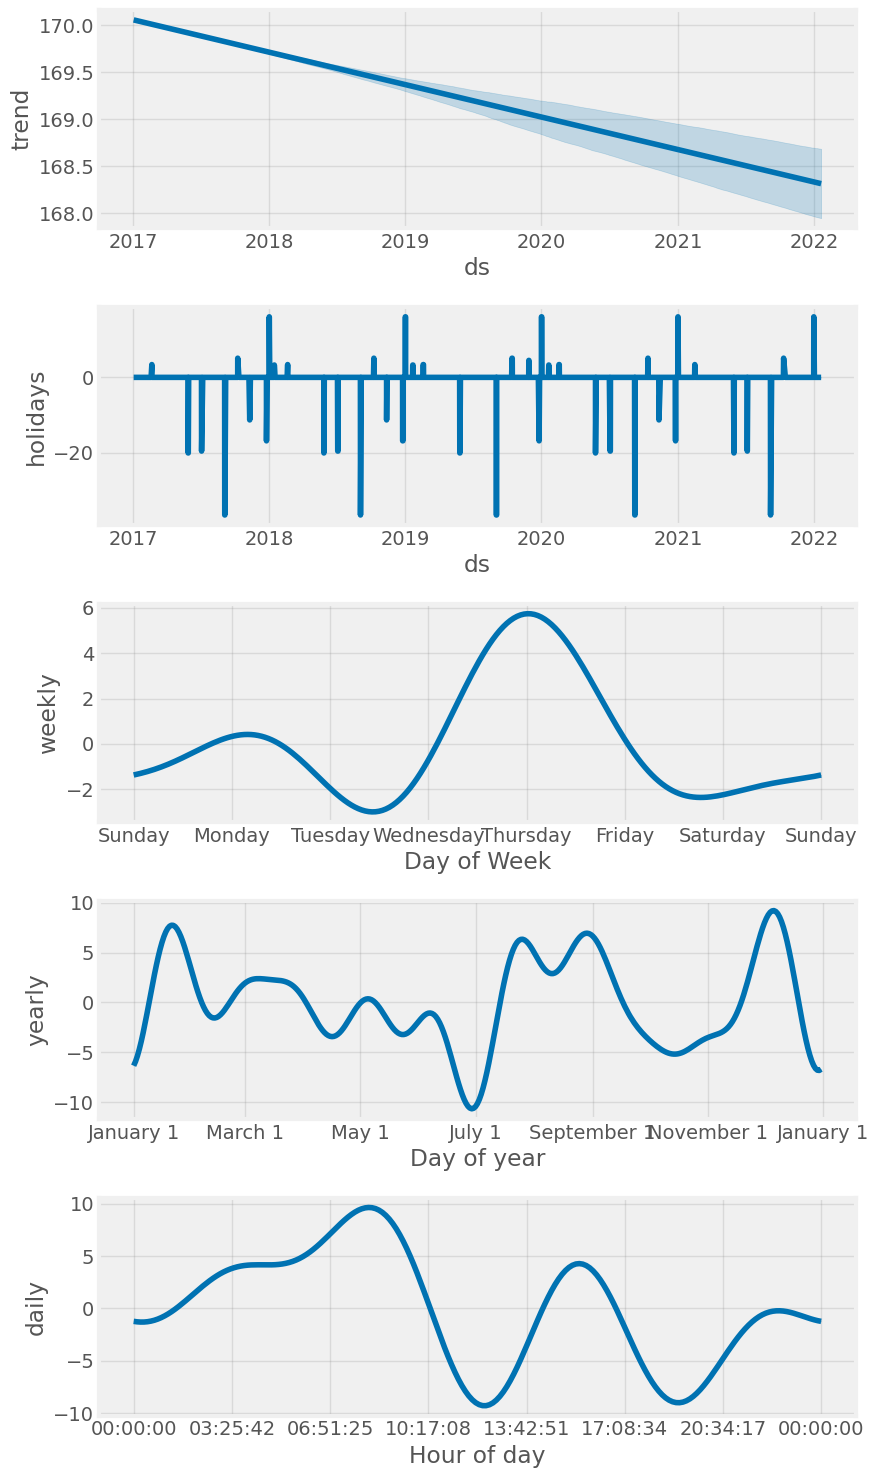

In [58]:
# let's plot the different components again, this time using the holidays data
fig = model_with_holidays.plot_components(
    tucson_test_frcst_with_hols)
plt.show()

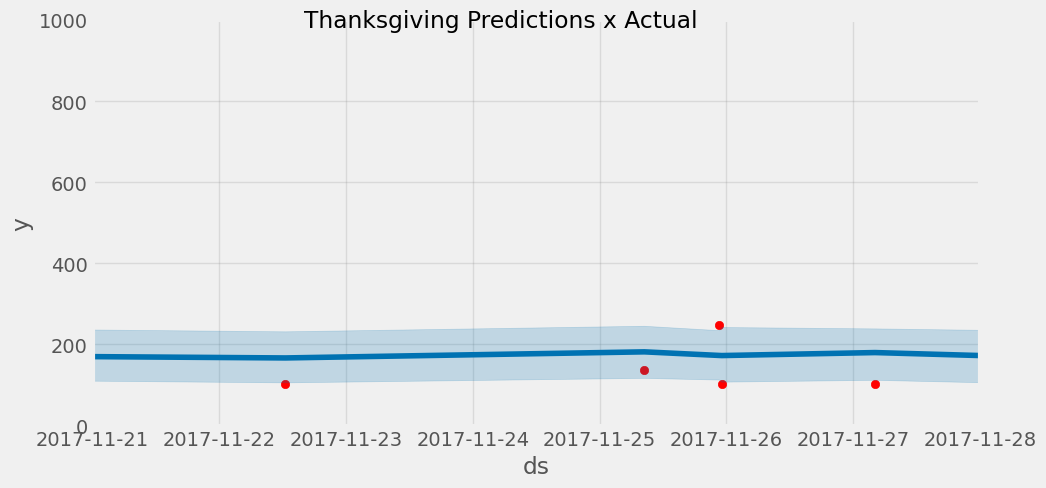

In [59]:
# plot the data for Thanksgiving week in 2017
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst_with_hols, ax=ax)

# christmas/new years week
from datetime import datetime

lower_date = datetime.strptime('2017-11-21', '%Y-%m-%d')
upper_date = datetime.strptime('2017-11-28', '%Y-%m-%d')


ax.set_xbound(lower=lower_date,
              upper=upper_date)
ax.set_ylim(0, 1000)
plot = plt.suptitle('Thanksgiving Predictions x Actual')

In [60]:
# evaluation metrics again, this time including holidays
# RMSE
np.sqrt(mean_squared_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst_with_hols['yhat']))

50.168394161053165

In [61]:
# MAE
mean_absolute_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst_with_hols['yhat'])

43.14924510859419

In [62]:
# MAPE
mean_absolute_percentage_error(y_true=tucson_test['review_count_test'],
                   y_pred=tucson_test_frcst_with_hols['yhat'])

25.58595254411804

After adding holiday data, we concluded that our results didn't change much, leading us to believe that holidays aren't very impactful, in this case.

### Forecast / Predictions

We decided to make a forecast for 10 years into the future - starting from 2017, which is the year where we made our train/test split.

In [63]:
# future predictions! using the prophet's make future dataframe component-> 10 years, yearly frequency
future = model.make_future_dataframe(periods=10, freq='y', include_history=False)
forecast = model_with_holidays.predict(future)

In [64]:
# show the new dataframe
forecast[['ds','yhat']].head(11)

,ds,yhat
0,2017-12-31 21:47:25,162.595659
1,2018-12-31 21:47:25,160.393588
2,2019-12-31 21:47:25,160.181045
3,2020-12-31 21:47:25,162.297459
4,2021-12-31 21:47:25,174.756446
5,2022-12-31 21:47:25,159.137389
6,2023-12-31 21:47:25,160.382156
7,2024-12-31 21:47:25,158.681697
8,2025-12-31 21:47:25,165.255455
9,2026-12-31 21:47:25,160.066671


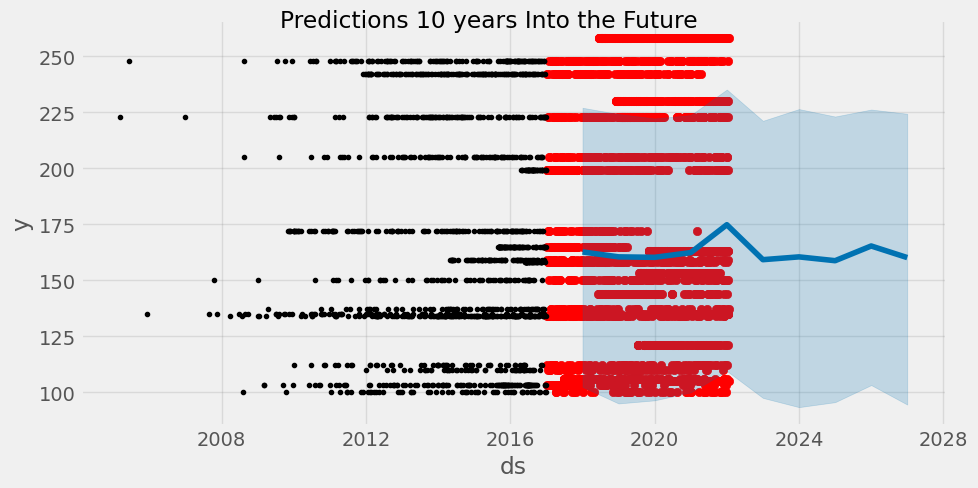

In [65]:
# plot the future predictions!
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(forecast, ax=ax)
plot = plt.suptitle('Predictions 10 years Into the Future')